# Project 1
## Paige Berrigan | 1290283
#### INFO 6148 NLP
#### October 14 2024

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec
import numpy as np

nlp = spacy.load('en_core_web_lg')  

file_path = r"C:\Users\paige\OneDrive\Desktop\6148 - NLP\Project 1\tripadvisor_hotel_reviews.csv"

def define_dataset(file_path):
    # limit full dataset to the first 5000 rows
    full_df = pd.read_csv(file_path).head(5000)
    
    # extract the "Review" and "Rating" columns from full_df
    reviews_df = full_df[['Review']].copy()
    ratings_df = full_df[['Rating']].copy()
    
    # Return the full dataset, reviews dataset (only text), and ratings dataset
    return full_df, reviews_df, ratings_df

full_df, reviews_df, ratings_df = define_dataset(file_path)


In [97]:
def clean_texts(reviews):
    cleaned_reviews = []
    
    for doc in nlp.pipe(reviews, batch_size=100, n_process=1): 
        # lowercase, remove punctuation, stop words, and filter words where the lemmatized version has more than 2 characters
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop and len(token.lemma_) > 2]
        cleaned_reviews.append(' '.join(tokens))
        
    return cleaned_reviews

# apply the optimized function
reviews_df['cleaned_review'] = clean_texts(reviews_df['Review'])

# print and check the first few cleaned reviews
print(reviews_df['cleaned_review'].head())



0    nice hotel expensive parking get good deal sta...
1    special charge diamond member hilton decide ch...
2    nice room experience hotel monaco seattle good...
3    unique great stay wonderful time hotel monaco ...
4    great stay great stay seahawk game awesome dow...
Name: cleaned_review, dtype: object


<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:6: SyntaxWarning: invalid escape sequence '\W'
C:\Users\paige\AppData\Local\Temp\ipykernel_12236\2507966529.py:6: SyntaxWarning: invalid escape sequence '\W'
  font_path = 'C:\Windows\Fonts\gulim.ttc' #font path here


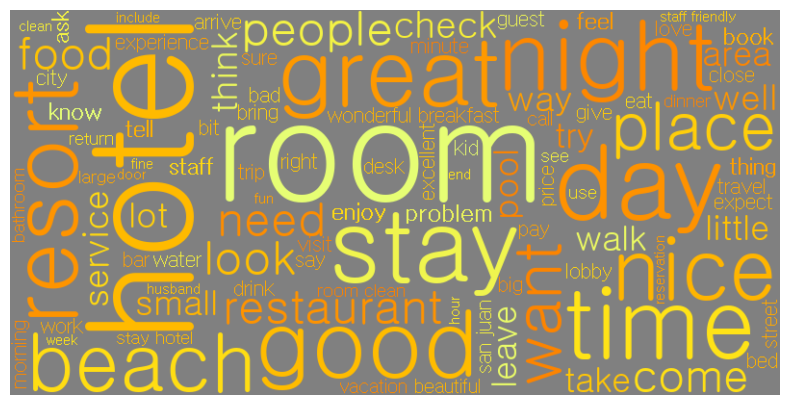

In [99]:
# Visualize All Reveiws

# combine all cleaned reviews into a single string so it can be passed through the function
all_cleaned_reviews = ' '.join(reviews_df['cleaned_review'])

font_path = 'C:\Windows\Fonts\gulim.ttc' # custom font for word cloud

wordcloud = WordCloud(
    width=800,           
    height=400,          
    background_color="grey",  
    colormap="Wistia", 
    max_words=100,        
    font_path=font_path,     
    max_font_size=150,    
    random_state=15       
).generate(all_cleaned_reviews) 

# show word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

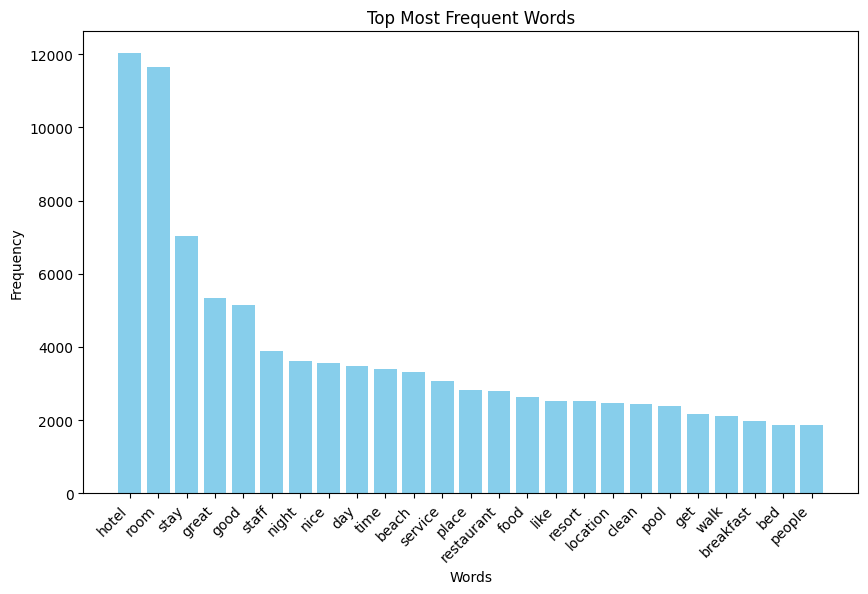

In [100]:
from collections import Counter

def get_most_frequent_words(reviews_df, num_top_words=25):
    all_cleaned_reviews = ' '.join(reviews_df['cleaned_review']) # put all the cleaned reviews into a single string
    words = all_cleaned_reviews.split() # tokenize string
    word_counts = Counter(words) # count the frequency of each word
    # find the most common words
    most_common_words = word_counts.most_common(num_top_words)
    return most_common_words

most_common_words = get_most_frequent_words(reviews_df, num_top_words=25)

# define a function to plot the most frequent words as a bar graph
def plot_most_frequent_words(most_common_words):
    #unpack words and frequencies
    words, counts = zip(*most_common_words)
    # create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top Most Frequent Words')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# call function
plot_most_frequent_words(most_common_words)

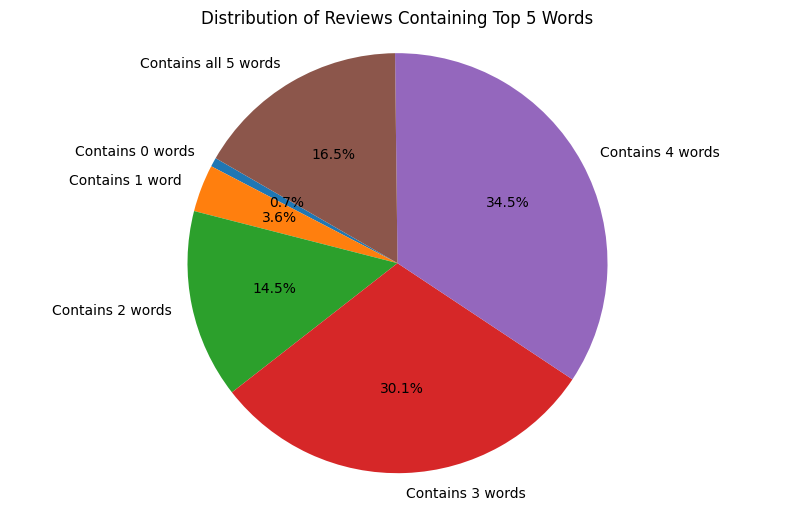

In [101]:
import matplotlib.pyplot as plt

# count amount of top words in 1 review
def count_words_in_review(review, top_words):
    return sum(1 for word in top_words if word in review)

# categorize reviews based on # of top words
def categorize_reviews(reviews_df, top_words):
    reviews_df['word_count'] = reviews_df['cleaned_review'].apply(lambda review: count_words_in_review(review, top_words))
    counts = reviews_df['word_count'].value_counts().sort_index()
    return counts

# plot a pie chart based on the distribution of reviews with 0-5 top words
def plot_pie_chart(counts):
    labels = ['Contains 0 words', 'Contains 1 word', 'Contains 2 words', 'Contains 3 words', 'Contains 4 words', 'Contains all 5 words']
    counts_filled = [counts.get(i) for i in range(6)]  
    
    # Create a pie chart
    plt.figure(figsize=(10, 6))  
    plt.pie(counts_filled, labels=labels, autopct='%1.1f%%', startangle=150)
    plt.title('Distribution of Reviews Containing Top 5 Words') 
    plt.axis('equal')
    plt.show()  

# Plot the pie chart showing the distribution of reviews by word count
plot_pie_chart(counts)


## Use 3 Word Embedding Techniques 

In [ ]:
# test 3 word embedding techniques with a simple logisitic regression model 
# to identify changes in the word embedding techniques 

In [118]:
# define x and y columns 
X = reviews_df['cleaned_review']  # Cleaned reviews
y = ratings_df['Rating']  # Corresponding ratings

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [123]:
# BOW embedding 

vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# define model that will be used for all embedding techniques
model = LogisticRegression(max_iter=5000)

# fit the model
model.fit(X_train_bow, y_train)  

# return classification report and scores 
y_pred_bow = model.predict(X_test_bow)
bow_accuracy = accuracy_score(y_test, y_pred_bow)
bow_report = classification_report(y_test, y_pred_bow, zero_division=0)


In [120]:
# TF-IDF

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# fit the model
model.fit(X_train_tfidf, y_train)

# return classification report and scores
y_pred_tfidf = model.predict(X_test_tfidf)
tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)
tfidf_report = classification_report(y_test, y_pred_tfidf)


In [121]:
# Word2Vec

# re-tokenize the cleaned reviews 
X_train_tokenized = [review.split() for review in X_train]
X_test_tokenized = [review.split() for review in X_test]

# training
word2vec_model = Word2Vec(X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# create a matrix for comparing
def get_word2vec_embeddings(reviews, model):
    embeddings = []
    for review in reviews:
        vectors = [model.wv[word] for word in review if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))  # Take the average of word vectors for the review
        else:
            embeddings.append(np.zeros(model.vector_size))  # If no word vectors are found, use a zero vector
    return np.array(embeddings)

X_train_w2v = get_word2vec_embeddings(X_train_tokenized, word2vec_model)
X_test_w2v = get_word2vec_embeddings(X_test_tokenized, word2vec_model)

# fit the model
model.fit(X_train_w2v, y_train)

# return classification report and scores
y_pred_w2v = model.predict(X_test_w2v)
w2v_accuracy = accuracy_score(y_test, y_pred_w2v)
w2v_report = classification_report(y_test, y_pred_w2v)



In [124]:
# Compare all embedding techniques

results = {
    'Embedding': ['Bag of Words', 'TF-IDF', 'Word2Vec'],
    'Accuracy': [bow_accuracy, tfidf_accuracy, w2v_accuracy]
}

# Display the results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# print the entire reports
print("\nBag of Words Classification Report:\n", bow_report)
print("\nTF-IDF Classification Report:\n", tfidf_report)
print("\nWord2Vec Classification Report:\n", w2v_report)

      Embedding  Accuracy
0  Bag of Words     0.563
1        TF-IDF     0.571
2      Word2Vec     0.530

Bag of Words Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.53      0.54        80
           2       0.31      0.30      0.30        93
           3       0.32      0.30      0.31       108
           4       0.53      0.50      0.52       311
           5       0.69      0.75      0.72       408

    accuracy                           0.56      1000
   macro avg       0.48      0.47      0.48      1000
weighted avg       0.56      0.56      0.56      1000


TF-IDF Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.50      0.57        80
           2       0.35      0.25      0.29        93
           3       0.39      0.11      0.17       108
           4       0.51      0.50      0.51       311
           5       0.63      0.83      0.72       408

    accurac

# Model 1 - Spacy Model

# Model 2 - KNN